In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# https://sci2s.ugr.es/keel/dataset.php?cod=86
df = pd.read_csv('./datasets/mammographic.csv')
print(df.shape)

(961, 6)


In [3]:
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
df.dtypes

BI-RADS      object
 Age         object
 Shape       object
 Margin      object
 Density     object
 Severity     int64
dtype: object

In [5]:
# replace ? to NaN
df = df.replace('?',np.nan)

# change dtypes: object to float
dic = {}
for i in df.columns[:-1]:
    dic[i] = float

df = df.astype(dic)

In [6]:
df.isnull().sum()

BI-RADS       2
 Age          5
 Shape       31
 Margin      48
 Density     76
 Severity     0
dtype: int64

In [7]:
df.dtypes

BI-RADS      float64
 Age         float64
 Shape       float64
 Margin      float64
 Density     float64
 Severity      int64
dtype: object

In [8]:
print('Number of missing value data:', df[df.isnull().any(axis=1)].shape[0])
print('Missing value ratio:', (df[df.isnull().any(axis=1)].shape[0] / df.shape[0]) *100)

Number of missing value data: 131
Missing value ratio: 13.631633714880333


# Missing data visualization

In [9]:
import missingno as msno

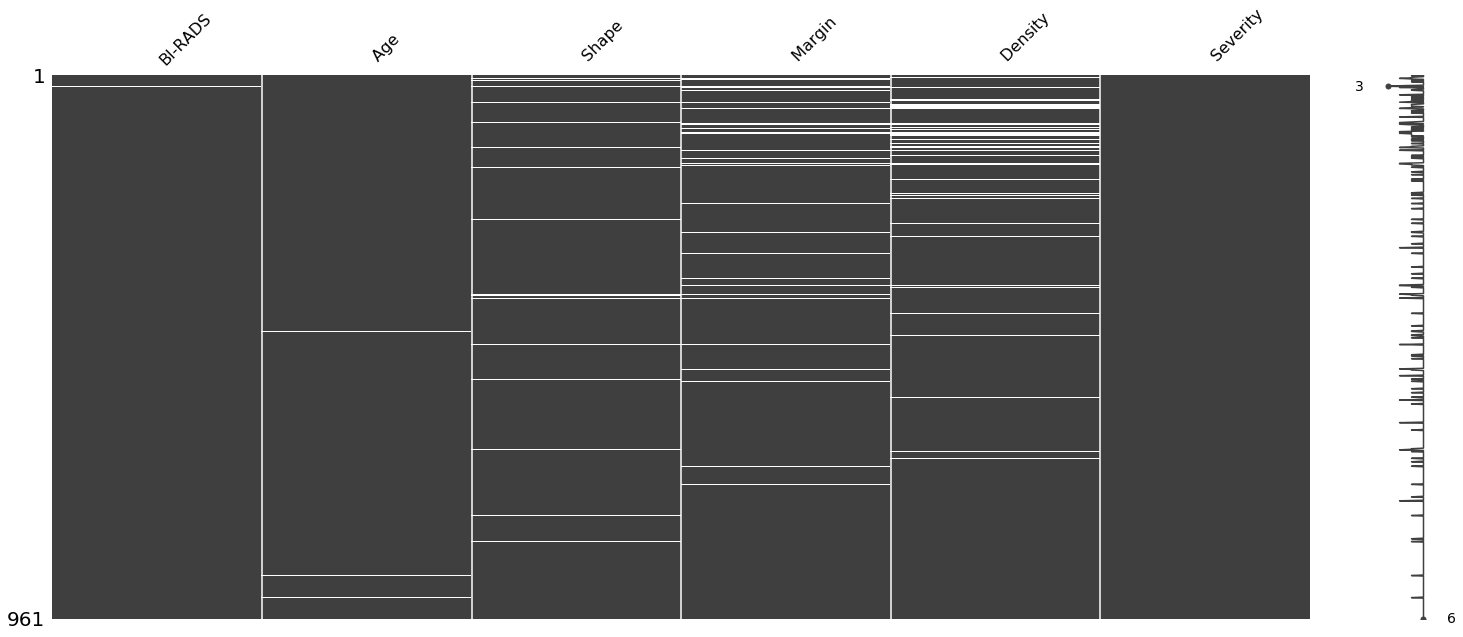

In [10]:
msno.matrix(df)

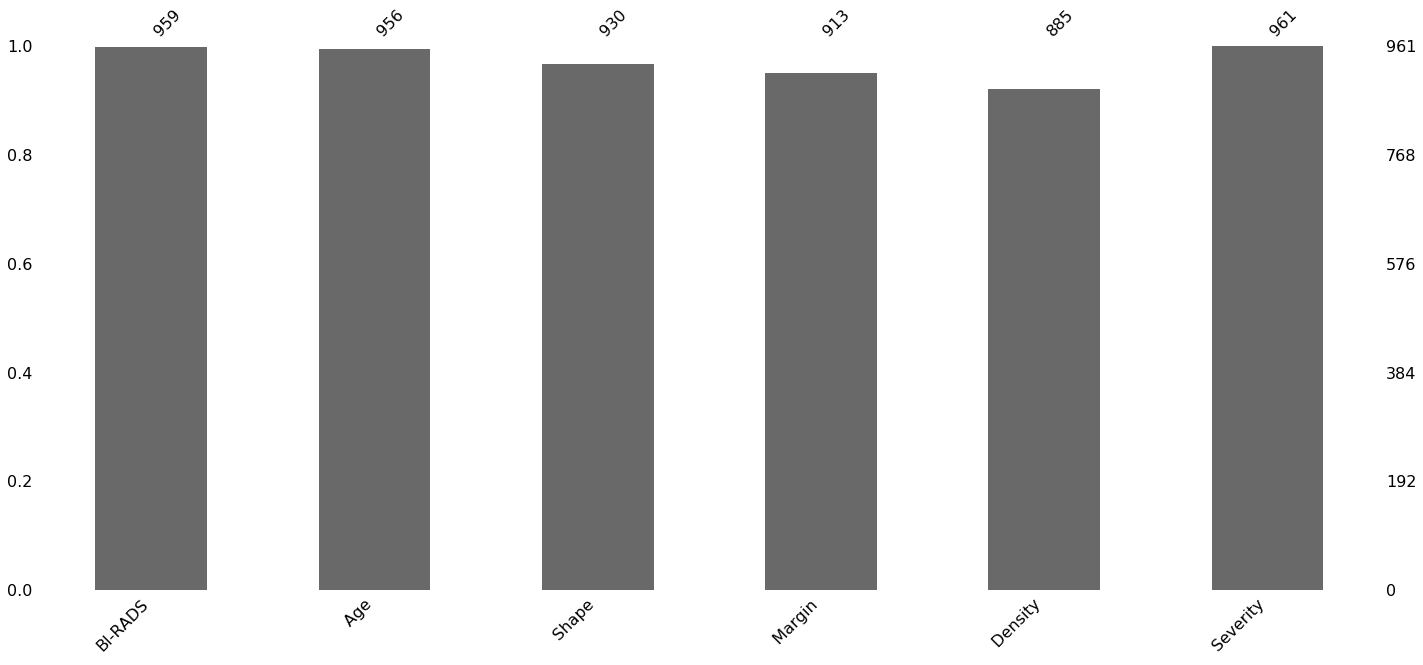

In [11]:
msno.bar(df)

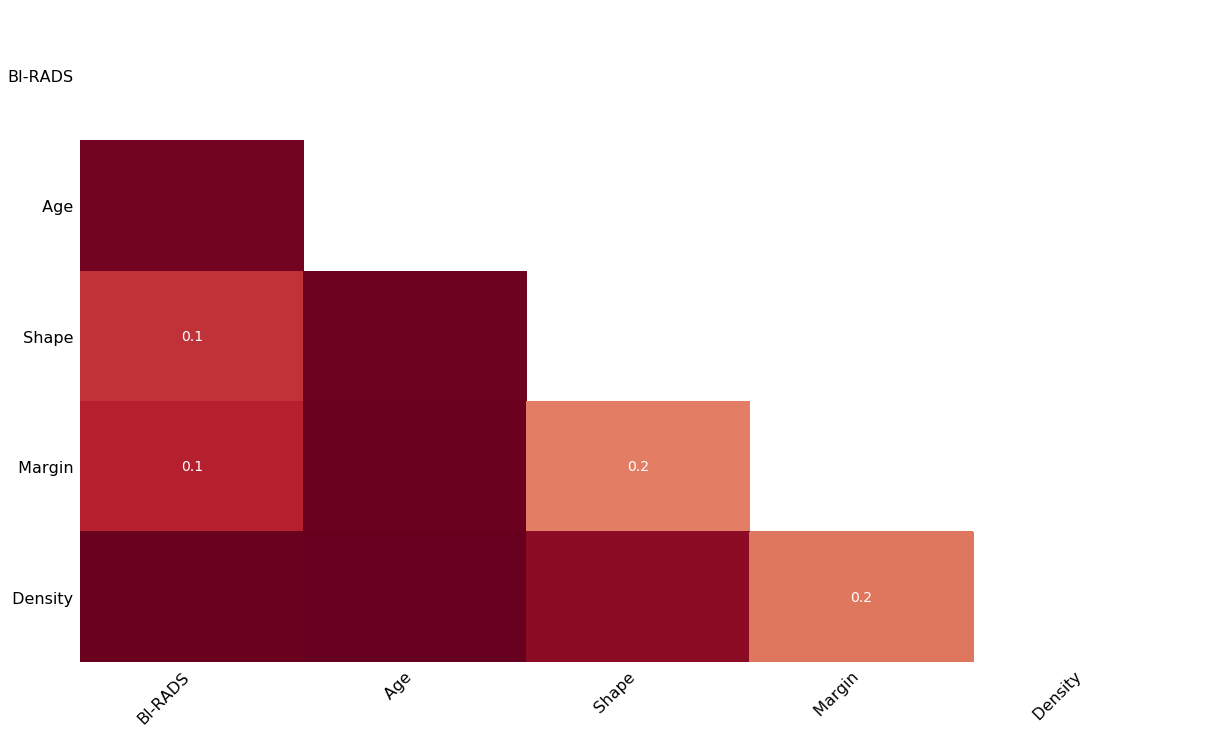

In [12]:
# Nullity correlation
msno.heatmap(df)

# Handling Missing Data
1. Delete
2. Impute
3. Predict

## Delete missing data

In [13]:
# delete NaN
df_del = df.dropna()

print('Original:', df.shape)
print('Delete:', df_del.shape)

Original: (961, 6)
Delete: (830, 6)


## Impute missing data

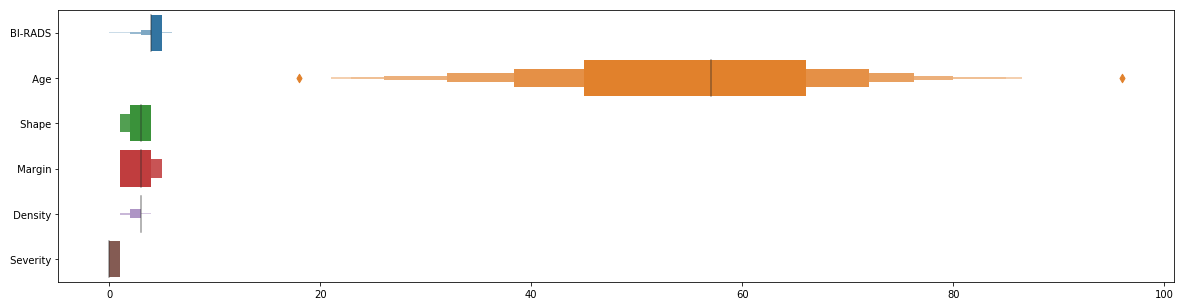

In [14]:
plt.figure(figsize=(20, 5))
sns.boxenplot(data=df, orient="h")

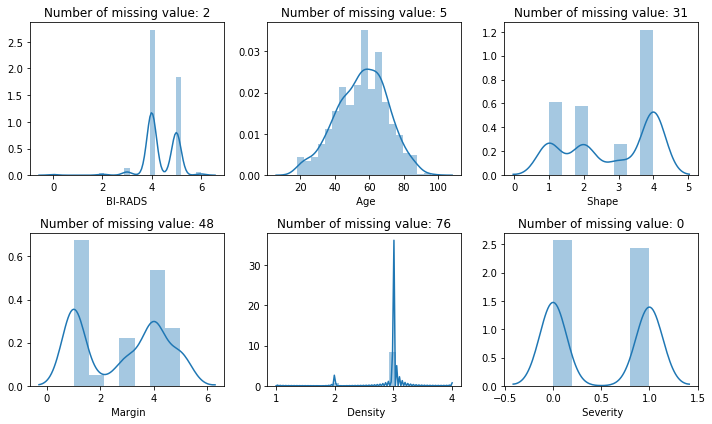

In [15]:
num_null = df.isnull().sum()
fig = plt.figure(figsize=(10, 6))

for i in range(1, df_del.shape[1]+1):
    fig.add_subplot(2, 3, i)
    sns.distplot(df_del[df_del.columns[i-1]])
    plt.title('Number of missing value: {}'.format(num_null[i-1]))

plt.tight_layout()

In [16]:
statistics = pd.DataFrame([df_del.mean(), df_del.median()])
statistics = pd.concat([statistics, df_del.mode()])
statistics.index = ['Mean', 'Median', 'Mode']
statistics

,BI-RADS,Age,Shape,Margin,Density,Severity
Mean,4.333735,55.781928,2.781928,2.813253,2.915663,0.485542
Median,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
Mode,4.000000,67.000000,4.000000,1.000000,3.000000,0.000000


In [17]:
# impute using column mean
df_mean = df.fillna(df.mean())

# linear interpolation
df_linear = df.interpolate(method='linear')

## Predict missing data

In [18]:
# Experimental API
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [19]:
dt = DecisionTreeRegressor(random_state=42)
knn = KNeighborsRegressor(n_neighbors=15)

estimator_dt = IterativeImputer(estimator=dt, random_state=42)
estimator_knn = IterativeImputer(estimator=knn, random_state=42)

In [20]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X = np.array(X)
y = np.array(y)

In [21]:
X_dt = estimator_dt.fit_transform(X, y)
X_knn = estimator_knn.fit_transform(X, y)

/home/yura/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


# Learning

In [22]:
# delete
X_del, y_del = df_del[df_del.columns[:-1]], df_del[df_del.columns[-1]]
X_del, y_del = np.array(X_del), np.array(y_del)

# mean
X_mean, y_mean = df_mean[df_mean.columns[:-1]], df_mean[df_mean.columns[-1]]
X_mean, y_mean = np.array(X_mean), np.array(y_mean)

# linear
X_linear, y_linear = df_linear[df_linear.columns[:-1]], df_linear[df_linear.columns[-1]]
X_linear, y_linear = np.array(X_linear), np.array(y_linear)

data_list = [[X_del, y_del], [X_mean, y_mean], [X_linear, y_linear], [X_dt, y], [X_knn, y]]

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
# scaling
data = []
for i in range(len(data_list)):
    # scaling
    scaler = StandardScaler()
    data_list[i][0] = scaler.fit_transform(data_list[i][0])
    
    # split
    data.append(train_test_split(data_list[i][0], data_list[i][1],
                                 test_size=0.3, shuffle=True, random_state=42))

In [25]:
# (data, split)
# 0:x_train, 1:x_test, 2:y_train, 3:y_test
np.array(data).shape

(5, 4)

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
clf = []

for i in range(len(data_list)):
    dt = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
    clf.append(dt.fit(data[i][0], data[i][2]))

# Evaluate

In [28]:
from sklearn import metrics

In [29]:
def calc_metrics(y_test, y_pred):
    pre = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    metrics_list = [pre, recall, acc, f1]
    
    return metrics_list

In [30]:
result = []

for i in range(len(clf)):
    y_pred = clf[i].predict(data[i][1])
    result.append(calc_metrics(data[i][3], y_pred))

In [31]:
result_df = pd.DataFrame(result, columns=['Precision', 'Recall', 'Acc', 'F-score'])
result_df = result_df.assign(Method=['Delete', 'Mean', 'Linear', 'DT', 'k-NN'])
result_df = result_df[['Method', 'Precision', 'Recall', 'Acc', 'F-score']]

In [32]:
result_df

,Method,Precision,Recall,Acc,F-score
0,Delete,0.746269,0.819672,0.775100,0.781250
1,Mean,0.805970,0.818182,0.826990,0.812030
2,Linear,0.803030,0.803030,0.820069,0.803030
3,DT,0.781022,0.810606,0.809689,0.795539
4,k-NN,0.789855,0.825758,0.820069,0.807407


In [33]:
result_mlt = pd.melt(result_df, id_vars='Method', var_name='Metrics', value_name='values')
result_mlt.head()

,Method,Metrics,values
0,Delete,Precision,0.746269
1,Mean,Precision,0.805970
2,Linear,Precision,0.803030
3,DT,Precision,0.781022
4,k-NN,Precision,0.789855


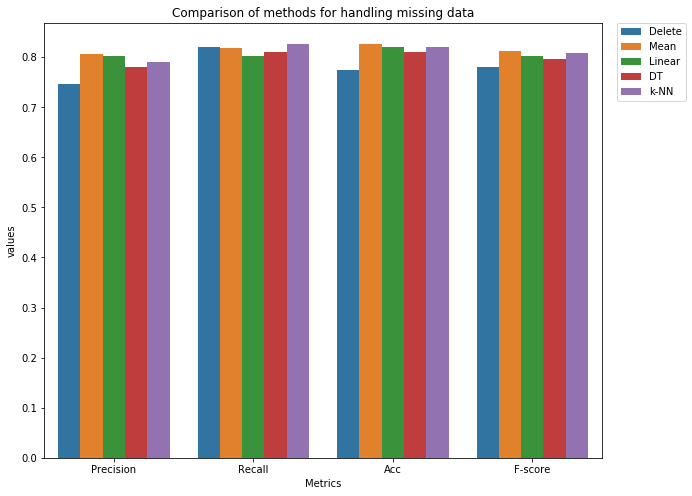

In [34]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Metrics', y='values', hue='Method', data=result_mlt)
plt.title('Comparison of methods for handling missing data')
plt.legend(loc='best', bbox_to_anchor=(1.15, 1), borderaxespad=0)